In [18]:
%matplotlib inline

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter,MultipleLocator
from netCDF4 import Dataset
from bs4 import BeautifulSoup
import urllib2
import matplotlib.gridspec as gridspec
import datetime

# most of the code adapted from pywrfplot
# http://code.google.com/p/pywrfplot/

timerun = (datetime.datetime.now()-datetime.timedelta(hours=8))  
date = timerun.strftime('%Y%m%d')
r = timerun.strftime('%H')

def myround(x, base=6):
    a = int(base * np.floor(float(x)/base))
    if a == 0:
        return '00'
    if a == 6:
        return '06'
    if a == 12 or a == 18:
        return a
run = myround(r)

# purpose: plot gfs data of Temperature and Dewpoint in skewT-log(p)-diagram
# first define constants

T_zero = 273.15
 
# P_top must be the same as what is used in the WRF simulation
P_top = 10000.
P_bot = 100000.
 
 
L = 2.501e6 # latent heat of vaporization
R = 287.04  # gas constant air
Rv = 461.5  # gas constant vapor
eps = R/Rv
 
cp = 1005.
cv = 718.
kappa = (cp-cv)/cp
g = 9.81
 
 
# constants used to calculate moist adiabatic lapse rate
# See formula 3.16 in Rogers&Yau
a = 2./7.
b = eps*L*L/(R*cp)
c = a*L/R

skewness = 37.5
# Defines the ranges of the plot, do not confuse with P_bot and P_top
P_b = 105000.
P_t = 10000.
dp = 100.
gfsdp = 2500
plevs = np.arange(P_b,P_t-1,-dp)
gfsplevs = np.arange(P_bot,P_top-1,-gfsdp)

In [23]:
# load data progtemp
hours = 3+24                  # tijd vooruit in uren, veelvoud van 3 gebruiken
coordN,coordE = 52.,5.        # coordinaten van sounding (Noord,Oost)

coE = int(2*coordE)
coN = int(2*coordN+180)
time = int(hours/3)

mainurl = 'http://nomads.ncep.noaa.gov:9090/dods/gfs_hd/gfs_hd%s/gfs_hd_%sz?'%(date,run)
url1 = 'tmpprs[%s][0:36][%s][%s]'%(time,coN,coE)           
url2 = ',tmp2m[%s][%s][%s]'%(time,coN,coE)
url3 = ',pressfc[%s][%s][%s]'%(time,coN,coE)
url4 = ',spfhprs[%s][0:36][%s][%s]'%(time,coN,coE)
url5 = ',spfh2m[%s][%s][%s]'%(time,coN,coE)
url6 = ',ugrdprs[%s][0:36][%s][%s]'%(time,coN,coE)
url7 = ',vgrdprs[%s][0:36][%s][%s]'%(time,coN,coE)
url8 = ',ugrd10m[%s][%s][%s]'%(time,coN,coE)
url9 = ',vgrd10m[%s][%s][%s]'%(time,coN,coE)

toturl = mainurl+url1+url2+url3+url4+url5+url6+url7+url8+url9

data=Dataset(toturl)

Temp =   data.variables["tmpprs"][:].squeeze()-T_zero
T2m =    data.variables['tmp2m'][:].squeeze()-T_zero
pres =   data.variables['pressfc'][:].squeeze()
rv =     data.variables['spfhprs'][:].squeeze()
rv2m =   data.variables['spfh2m'][:].squeeze()
u =      data.variables['ugrdprs'][:].squeeze()
v =      data.variables['vgrdprs'][:].squeeze()
u10m =   data.variables['ugrd10m'][:].squeeze()
v10m =   data.variables['vgrd10m'][:].squeeze()
 
print 'done'

done


In [24]:
#definitions
def _skewnessTerm(P):
    return skewness * np.log(P_bot/P)

def dewpt(r,p):
    """Returns dewpoint temperature (Celcius) for given mixing ratio (kg/kg)
    and pressure (hectopascal)"""
    return 243.5/(17.67/(np.log((r*p/(r+eps))/6.112))-1)

def es(T):
    """Returns saturation vapor pressure (Pascal) at temperature T (Celsius)
    Formula 2.17 in Rogers&Yau"""
    return 611.2*np.exp(17.67*T/(T+243.5))

def gamma_s(T,p):
    """Calculates moist adiabatic lapse rate for T (Celsius) and p (Pa)
    Note: We calculate dT/dp, not dT/dz
    See formula 3.16 in Rogers&Yau for dT/dz, but this must be combined with 
    the dry adiabatic lapse rate (gamma = g/cp) and the
    inverse of the hydrostatic equation (dz/dp = -RT/pg)"""
    esat = es(T)
    wsat = eps*esat/(p-esat) # Rogers&Yau 2.18
    numer = a*(T+T_zero) + c*wsat
    denom = p * (1 + b*wsat/((T+T_zero)**2))
    return numer/denom # Rogers&Yau 3.16

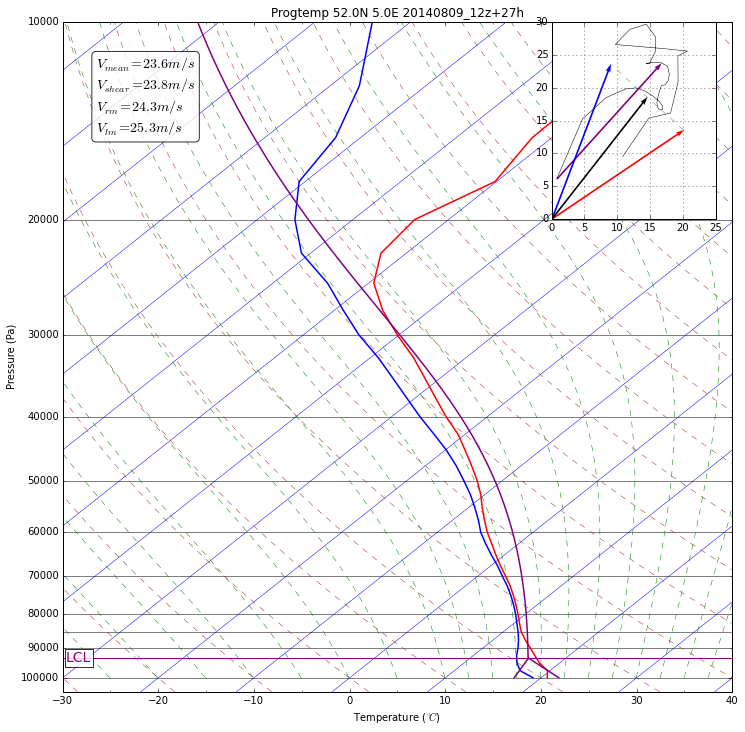

In [25]:
################################################# create figure
fig = plt.figure(figsize=(12,12))
#G = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(111)
title = 'Progtemp %.1fN %.1fE %s_%sz+%sh'%(coordN,coordE,date,run,hours)
plt.title(title)
ax2 = fig.add_subplot(333)



Tmin,Tmax = -30,40

ax.axis([Tmin,Tmax,P_b,P_t])
ax.set_xlabel('Temperature ($^{\circ}\! C$)')
xticks = np.arange(Tmin,Tmax+1,5)
ax.set_xticks(xticks,['' if tick%10!=0 else str(tick) for tick in xticks])
ax.set_ylabel('Pressure (Pa)')
yticks = np.arange(P_bot,P_t-1,-10**4)
ax.set_yscale('log')


ax.yaxis.set_major_formatter(FormatStrFormatter('%1.0f'))
ax.yaxis.set_minor_formatter(FormatStrFormatter('%1.0f'))

# plot isotherms
for temp in np.arange(-150,50,10):
    ax.plot(temp + _skewnessTerm(plevs), plevs, color = ('blue'), linestyle=('solid'), linewidth = .5)

# plot isobars
for n in yticks:
    ax.plot([Tmin,Tmax], [n,n], color = 'black', linewidth = .5)
ax.plot([Tmin,Tmax],[85000,85000], color = 'black', linewidth = .5)   

# plot dry adiabats
for tk in T_zero+np.arange(-30,210,10):
    dry_adiabat = tk * (plevs/P_bot)**kappa - T_zero + _skewnessTerm(plevs)
    ax.plot(dry_adiabat, plevs, color = 'brown', linestyle='dashed', linewidth = .5)
 
# plot moist adiabats  
ps = [p for p in plevs if p<=P_bot]
for temp in np.concatenate((np.arange(Tmin,10.1,5.),np.arange(12.5,Tmax+.1,2.5))):
    moist_adiabat = []
    for p in ps:
        temp -= dp*gamma_s(temp,p)
        moist_adiabat.append(temp  + _skewnessTerm(p))
    ax.plot(moist_adiabat, ps, color = 'green',linestyle = 'dashed', linewidth = .5)
    
################################################ plot temperature and dewpoint temperature

# calculate dewpoint temperatures from specific humidity and pressure
Td = dewpt(rv,0.01*gfsplevs)
Td2m = dewpt(rv2m,0.01*pres)

# create new lists so that levels below surface level are not included
Tempnewlist,Tdnewlist,Presnewlist,rnewlist,unewlist,vnewlist = [[] for i in range(6)]
for levs,temps,dewpts,mixrat,vecu,vecv in zip(gfsplevs,Temp,Td,rv,u,v):
    if levs < pres:
        Tempnewlist.append(temps)
        Tdnewlist.append(dewpts)
        Presnewlist.append(levs)
        rnewlist.append(mixrat)
        unewlist.append(vecu)
        vnewlist.append(vecv)

# add surface values to the array
Tempnew = np.concatenate([[T2m],np.array(Tempnewlist)])  
Tdnew = np.concatenate([[Td2m],np.array(Tdnewlist)])  
Presnew = np.concatenate([[pres],np.array(Presnewlist)]) 
rnew = np.concatenate([[rv2m],np.array(rnewlist)]) 
unew = np.concatenate([[u10m],np.array(unewlist)]) 
vnew = np.concatenate([[v10m],np.array(vnewlist)])


# plot the actual graphs
ax.plot(Tempnew + _skewnessTerm(Presnew),Presnew, color=('red'),linestyle=('solid'),linewidth= 1.5)
ax.plot(Tdnew + _skewnessTerm(Presnew),Presnew, color=('blue'),linestyle=('solid'),linewidth= 1.5)


################################################# add hodograph to figure
# calulate values

# make arrays for wind up to 500hpa
u500 = u[:22]
v500 = v[:22]

u_str = sum(u500)/len(u500) # storm relative u
v_str = sum(v500)/len(v500) # storm relative v

u_dls = u[21]-u10m # u wind component deep layer shear
v_dls = v[21]-v10m # v wind component deep layer shear

dls = (u_dls**2.+v_dls**2.)**.5 # deep layer shear
mean = (u_str**2.+v_str**2.)**.5 # mean wind 0-6km

#BRN_U = u_str-u_0_500
#BRN_V = v_str-v_0_500
#BRN_WIND = (BRN_U**2+BRN_V**2)**.5


V_shear = [u_dls,v_dls,0] # shear vector
unit_k = [0,0,1] # vertical unit vector

u_rm_mean,v_rm_mean,w_rm_mean = 7.5*np.cross(V_shear/dls,unit_k)

u_rm = u_str+u_rm_mean # u component rightmover
v_rm = v_str+v_rm_mean # v component rightmover
u_lm = u_str-u_rm_mean # u component leftmover
v_lm = v_str-v_rm_mean # v component leftmover

rm = (u_rm**2+v_rm**2)**.5 # wind speed rightmover
lm = (u_lm**2+v_lm**2)**.5 # wind speed leftmover

# plot hodograph
ax2.set_aspect('equal')
ax2.quiver(u10m,v10m,u_dls,v_dls,color='purple',angles='xy', scale_units='xy', scale=1,width=.01)
ax2.quiver(0,0,u_rm,v_rm,color='red',angles='xy', scale_units='xy', scale=1,width=.01)
ax2.quiver(0,0,u_lm,v_lm,color='blue',angles='xy', scale_units='xy', scale=1,width=.01)
ax2.quiver(0,0,u_str,v_str,color='k',angles='xy', scale_units='xy', scale=1,width=.01)
ax2.plot(unew,vnew,color='k',linewidth=0.5)
ax2.plot([u_rm,u_lm],[v_rm,v_lm],color='grey',linewidth=0.5,linestyle='--')

ax2.grid()

#################################################### plot parcel trajectories
# surface pressure levels instead of pressure levels

# calculate the dry trajectories for Temp and Td
mixedlayer_r = sum(rnew[:4])/len(rnew[:4])
mixedlayer_temp = sum(Tempnew[:4])/len(Tempnew[:4])
mixedlayer_pres = sum(Presnew[:4])/len(Presnew[:4])

splevs = np.arange(pres,P_t-1,-dp)
# use mixed layer values
dryTd = dewpt(mixedlayer_r,0.01*splevs)
dryT = (T_zero+mixedlayer_temp) * (splevs/mixedlayer_pres)**kappa - T_zero



#use surface values
#dryTd = dewpt(rv2m,0.01*splevs)
#dryT = (T_zero+T2m) * (splevs/pres)**kappa - T_zero

# calculate the index number of the LCL
TminTd = abs(dryT-dryTd)
lcli = np.nonzero(TminTd == TminTd.min())[0].squeeze()


moistT = []
temp = dryT[lcli]
for ps in splevs[lcli:]:
    temp -= dp*gamma_s(temp,ps)
    moistT.append(temp)
    
# calculate the trajectories arrays
plotT = dryT[:lcli]
plotTd = dryTd[:lcli]
plotp = splevs[:lcli]
moistp = splevs[lcli:]

# plot the trajectories
ax.plot(moistT+ _skewnessTerm(moistp),moistp, color = 'purple', linestyle = 'solid', linewidth = 1.5)
ax.plot(plotT+ _skewnessTerm(plotp),plotp, color = 'purple', linestyle='solid', linewidth = 1.5)
ax.plot(plotTd+ _skewnessTerm(plotp),plotp, color='purple', linestyle='solid',linewidth= 1.5)

# plot LCL
lcl = splevs[lcli]
ax.plot([Tmin,Tmax],[lcl,lcl], color = 'purple', linestyle = 'solid', linewidth = 1.0)
ax.text(Tmin+.5,lcl,'LCL',color='purple',ha='left',va='center',fontsize=14,\
        bbox=dict(edgecolor='black',facecolor='white', alpha=0.8))

#show variables
textstr = '$V_{mean}=%.1fm/s$\n$V_{shear}=%.1fm/s$\n$V_{rm}=%.1fm/s$\n$V_{lm}=%.1fm/s$'%(mean,dls,rm,lm)


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round',facecolor='white', alpha=0.8)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig("F:\\Afbeeldingen\\Soundings\\%s.png"%title,bbox_inches='tight',transparent=True)